For info on XGBoost, read this file [XGBoost.md](../../../../docs/ml_models/XGBoost.md)

---
# XGBoost Model


<>:29: SyntaxWarning: invalid escape sequence '\.'
<>:29: SyntaxWarning: invalid escape sequence '\.'
C:\Users\gosha\AppData\Local\Temp\ipykernel_31112\3243951129.py:29: SyntaxWarning: invalid escape sequence '\.'
  return pd.to_numeric(colseries.astype(str).str.replace('[^0-9\.]', '', regex=True), errors='coerce')
c:\Users\gosha\programming\BALL\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:29:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


loaded 1795 rows with 0 missing injury counts
  POSITION  total_days_out  injury_count
0     PF-C           317.0          24.0
1    SG-SF             0.0           0.0
2     PF-C             0.0           0.0
players with injury count > 0: 48.47%
Accuracy: 0.6636971046770601
Classification report:
              precision    recall  f1-score   support

   no injury       0.69      0.62      0.65       231
      injury       0.64      0.71      0.67       218

    accuracy                           0.66       449
   macro avg       0.67      0.67      0.66       449
weighted avg       0.67      0.66      0.66       449



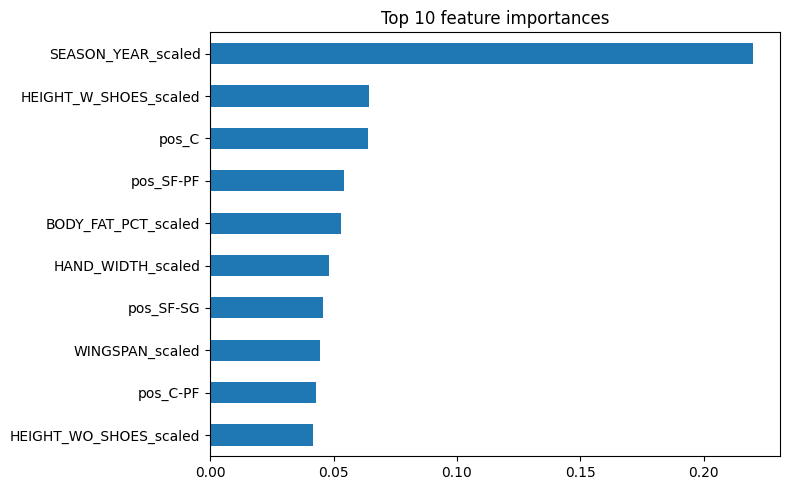

In [ ]:
# required imports

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from matplotlib import pyplot as plt
import sqlite3
import os

# define path to database and load injury profile table
DB_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'BALL.db'))
conn = sqlite3.connect(DB_PATH)
query = "SELECT * FROM player_injury_profile"
df = pd.read_sql_query(query, conn)
conn.close()

print(f"Loaded {df.shape[0]} rows with {df['injury_count'].isna().sum()} missing injury counts")
print(df[['POSITION', 'total_days_out', 'injury_count']].head(3))

# create binary target (injured at least once in profile)
df['injury_flag'] = (df['injury_count'] > 0).astype(int)
target_rate = df['injury_flag'].mean()
print(f"Players with injury_count > 0: {target_rate:.2%}")

# numeric columns that need coercion
def coerce(colseries):
    return pd.to_numeric(colseries.astype(str).str.replace('[^0-9\.]', '', regex=True), errors='coerce')

numeric_fields = [
    'HEIGHT_WO_SHOES',
    'HEIGHT_W_SHOES',
    'WEIGHT',
    'WINGSPAN',
    'STANDING_REACH',
    'BODY_FAT_PCT',
    'HAND_LENGTH',
    'HAND_WIDTH',
    'SEASON_YEAR'
]

X_numeric = pd.DataFrame({field: coerce(df[field]) for field in numeric_fields})
X_numeric = X_numeric.fillna(0)

# scale numeric data for better convergence
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_numeric),
    columns=[f + '_scaled' for f in numeric_fields],
    index=df.index
)

# encode position information
position = df['POSITION'].fillna('Unknown')
pos_dummies = pd.get_dummies(position, prefix='pos')

# combine numeric and categorical features
X = pd.concat([X_scaled, pos_dummies], axis=1)
X = X.astype(float)

y = df['injury_flag']

# split dataset so we can evaluate generalization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# configure and train the XGBoost classifier
default_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_estimators': 150,
    'max_depth': 4,
    'learning_rate': 0.1,
    'random_state': 42
}
model = xgb.XGBClassifier(**default_params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# evaluation metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification report:')
print(classification_report(y_test, y_pred, target_names=['no injury', 'injury']))

# plot feature importances so you can see what shaped the decision boundary
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).sort_values().plot(
    kind='barh', figsize=(8, 5), title='Top 10 feature importances'
)
plt.tight_layout()
plt.show()

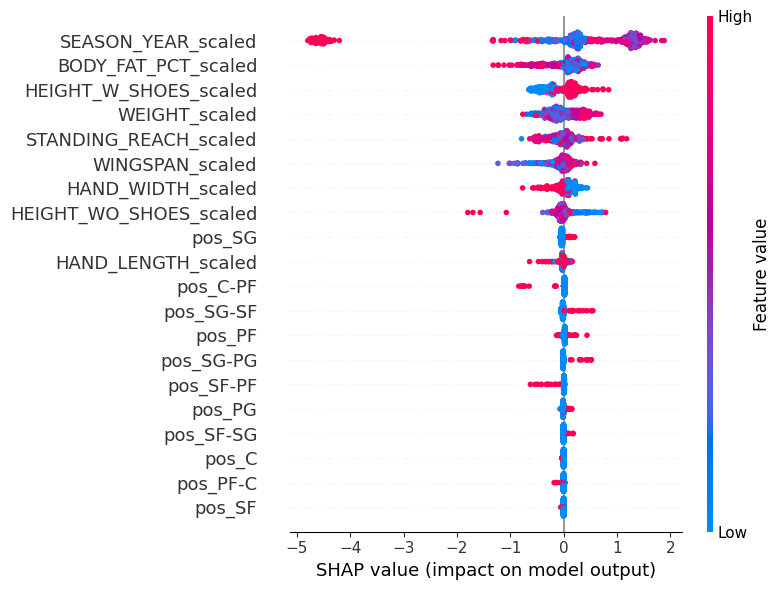

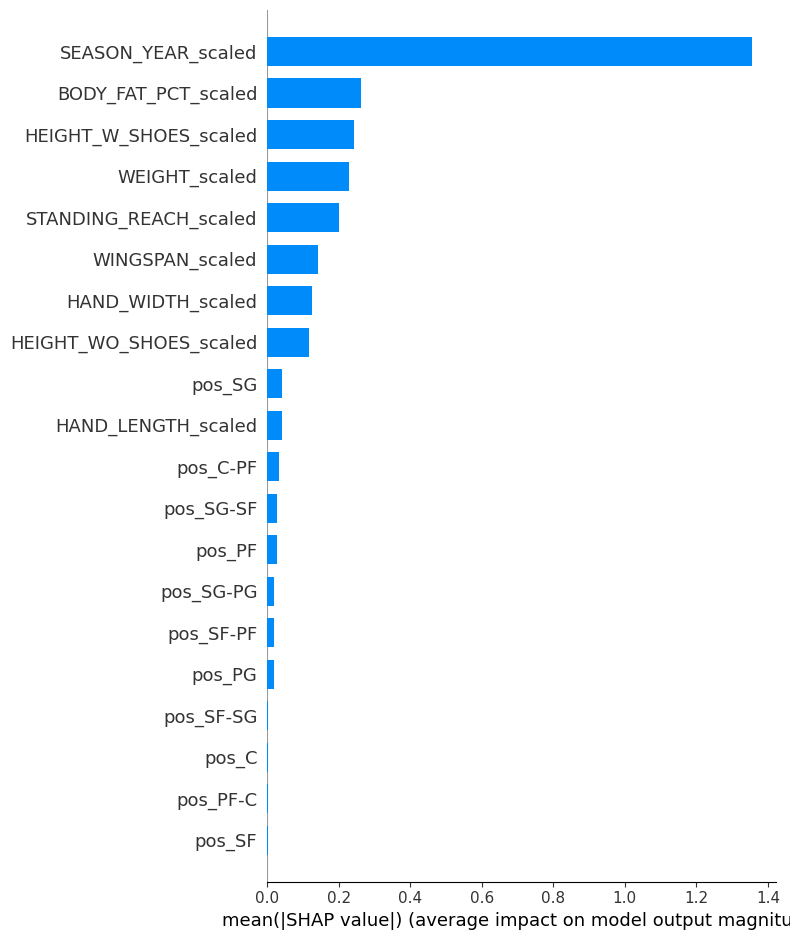

In [10]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(8, 6)
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

### SHAP analysis
- Call `shap.Explainer` with the trained XGBoost model and the training set so SHAP can learn the baseline expectation and the interaction mechanics the model settled on
- The dot summary plot shows how high/low values for the top features push the prediction toward the "injury" or "no injury" class, letting you spot consistent risk drivers
- The bar summary ranks features by their mean absolute SHAP values, making it easy to report which physical stats the model finds most influential overall